# Classifaction prediction of corporate ESG Ratings based on Fortune 1000 company data

From natural resource scarcity to changing governance standards, from global
workforce management to the evolving regulatory landscape, ESG factors can affect
the long-term risk-and-return profile of investment portfolios. MSCI ESG Ratings are
designed to help investors understand ESG risks and opportunities and integrate these
factors into their portfolio construction and management process.

**MSCI ESG Ratings Methodology Overview**

MSCI ESG Ratings aim to measure a company’s resilience to long-term,
financially relevant ESG risks.
- Of the negative externalities that companies in an industry generate, which
issues may turn into unanticipated costs for companies in the medium to longterm?
- Conversely, which ESG issues affecting an industry may turn into opportunities for companies in the medium to long-term? More specifically, the MSCI ESG Ratings model seeks to answer four key uestions about companies:
 - What are the most significant ESG risks and opportunities facing a companyand its industry?
 - How exposed is the company to those key risks and/or opportunities?
 - How well is the company managing key risks and/or opportunities?
 - What is the overall picture of a company and how does it compare to itsglobal industry peers?

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve


from pandasql import sqldf

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
import xgboost


from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
F1_000_df = pd.read_csv('./Data/Fortune_1000.csv')

In [3]:
esg_info_df = pd.read_csv('./Data/MSCI_esg.csv')

### Initial Data Cleaning

esg_info column names

In [4]:
esg_info_df.rename(columns=lambda x: x.lower(), inplace=True)
esg_info_df.columns = esg_info_df.columns.str.replace(' ','_')

# Same for F1000
F1_000_df.rename(columns=lambda x: x.lower(), inplace=True)
F1_000_df.columns = F1_000_df.columns.str.replace(' ','_')
F1_000_df.rename(columns = {'num._of_employees':'num_of_employees'}, inplace = True)

## Dropping ESG_info rows

In [5]:
esg_info_df.dropna(subset=['ticker']).shape

(10441, 10)

In [6]:
esg_info_df.dropna(subset=['ticker'], inplace=True)

## Creating full dataframe

In [7]:
pysqldf = lambda q: sqldf(q, globals())

In [8]:
q1 = """
SELECT
    f1.company,
    f1.rank,
    f1.revenue,
    f1.profit,
    f1.num_of_employees,
    f1.sector,
    env.subsector,
    f1.state,
    f1.newcomer,
    f1.ceo_founder,
    f1.ceo_woman,
    f1.profitable,
    f1.market_cap,
    env.overall_esg_rating,
    env.overall_esg_score,
    env.environmental_score,
    env.social_score,
    env.governance_score
FROM
    F1_000_df AS f1
    INNER JOIN esg_info_df AS env
    ON f1.ticker = env.ticker
     """
df = pysqldf(q1)


### Drop Duplicates

In [9]:
df.drop_duplicates(keep='first', inplace=True)

### Deal with with missing values

Drop missing profit value

In [10]:
df.dropna(subset=['profit'], inplace=True)

I Will need to build an imputer for the 6 missing values in subsector in my model

# Fix data types

Looks like market cap is a string - converting to integer

In [11]:
df.market_cap = df.market_cap.astype(float)

Additionally, revenue, profit, and market cap are in million dollar units - fixing the units to be in dollars (new value = old value * 1,000,000)

In [12]:
df.revenue = df.revenue * 1_000_000
df.profit = df.profit * 1_000_000
df.market_cap = df.market_cap * 1_000_000

Finally, change all object columns to lowercase/get rid of whitespace

In [13]:
obj_list = list(df.select_dtypes(include=['object']).columns)

obj_list

['company',
 'sector',
 'subsector',
 'state',
 'newcomer',
 'ceo_founder',
 'ceo_woman',
 'profitable',
 'overall_esg_rating']

In [14]:
for item in obj_list:
    df[item] = df[item].str.replace("\$|,|\.|-+| &+", '', regex = True).astype('object')
    df[item] = df[item].str.replace(" ", '_', regex = True).astype('object')
    df[item] = df[item].str.lower()

# EDA

In [15]:
def millions_formatter(x, pos):
    return f'{x / 1000000}'

In [16]:
df.describe()

,rank,revenue,profit,num_of_employees,market_cap,overall_esg_score,environmental_score,social_score,governance_score
count,1098.000000,1.098000e+03,1.098000e+03,1.098000e+03,1.098000e+03,1098.000000,1098.000000,1098.000000,1098.000000
mean,475.618397,1.663049e+10,1.401740e+09,3.487931e+04,3.560170e+10,5.706785,5.462113,4.802459,5.354736
std,285.844599,3.431090e+10,3.704468e+09,8.749232e+04,1.231368e+11,1.894967,2.369435,1.482958,1.171968
min,1.000000,1.990300e+09,-8.506000e+09,5.100000e+01,3.960000e+07,0.000000,0.000000,0.000000,0.500000
25%,227.000000,3.376850e+09,1.377000e+08,7.324500e+03,2.277975e+09,4.300000,3.600000,3.800000,4.700000
50%,462.500000,6.493800e+09,4.615000e+08,1.400000e+04,8.042550e+09,5.700000,5.200000,4.800000,5.500000
75%,713.750000,1.417520e+10,1.358000e+09,3.095000e+04,2.731200e+10,7.075000,7.100000,5.700000,6.200000
max,1000.000000,5.239640e+11,5.525600e+10,2.200000e+06,2.221176e+12,10.000000,10.000000,10.000000,8.600000


''

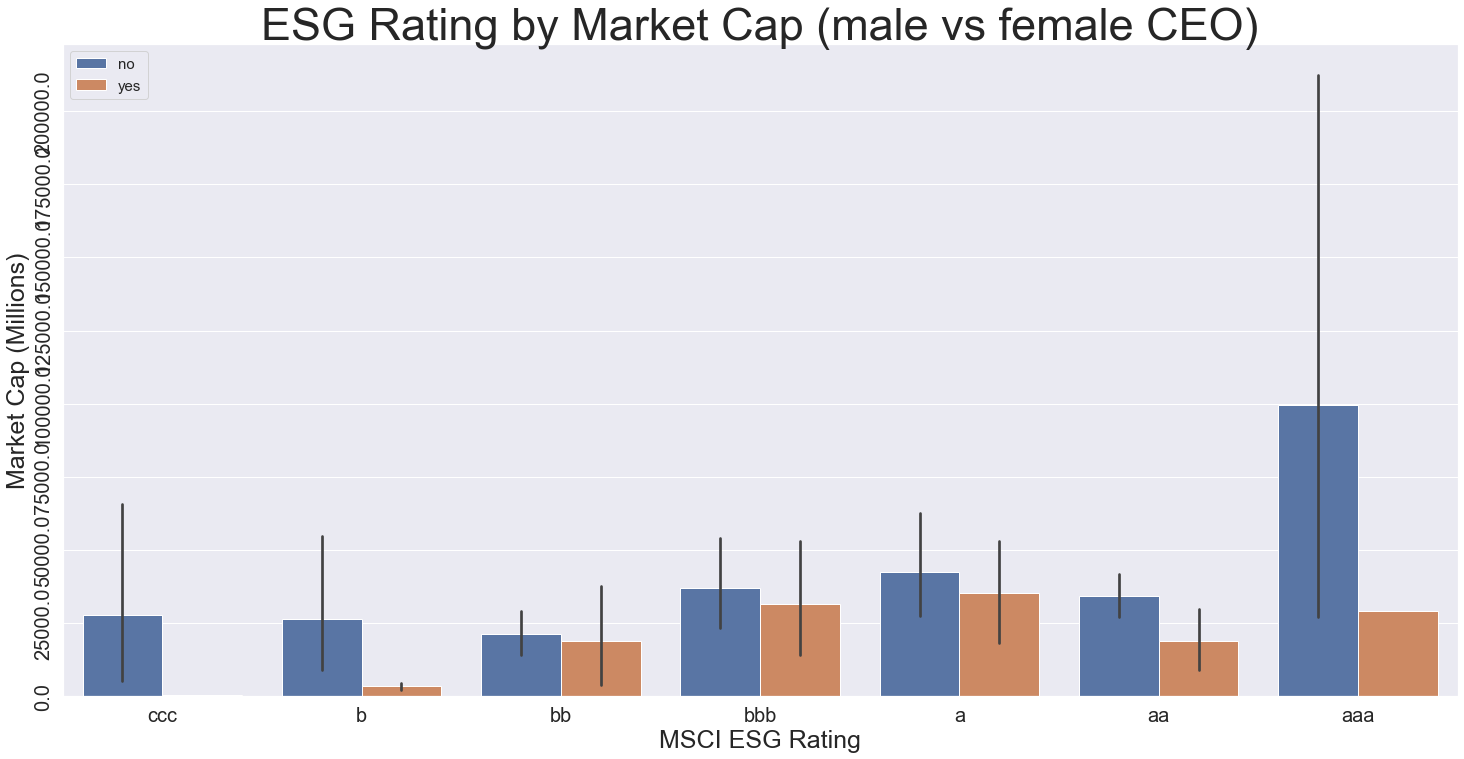

In [17]:
sns.set(rc={'figure.figsize':(25,12)})

ax = sns.barplot(x="overall_esg_rating", y="market_cap", hue="ceo_woman", data=df, order=['ccc','b','bb','bbb','a','aa','aaa'])

plt.title('ESG Rating by Market Cap (male vs female CEO)', fontsize=45, pad=5)
plt.ylabel('Market Cap (Millions)', fontsize=25)
plt.xlabel('MSCI ESG Rating', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=90, va='center')

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

ax.legend(loc='upper left', fontsize=15)
;

This mostly shows the deiscrepancy between the # of male vs female CEOs than a meaningful difference in ESG score by market cap - I'll try with founder status

''

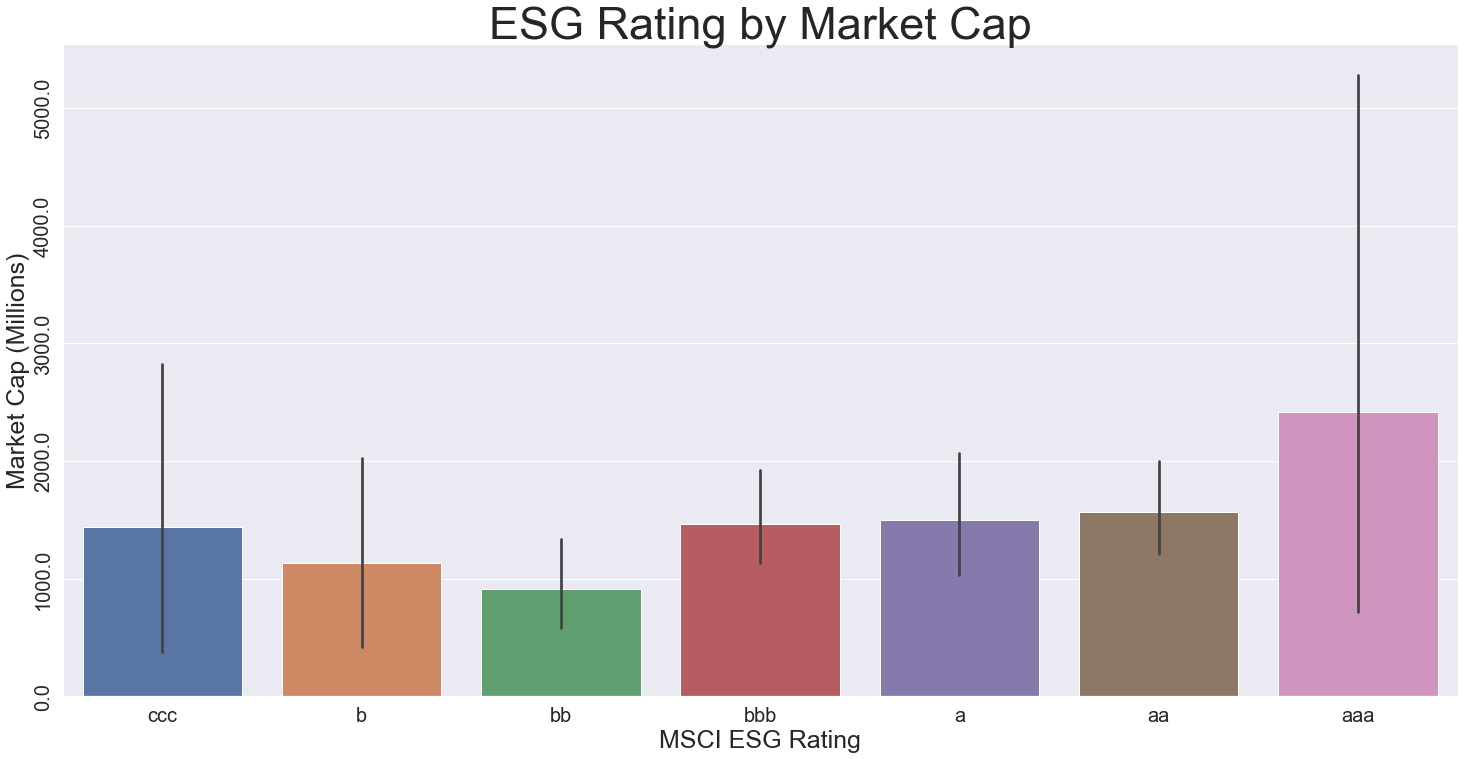

In [18]:
sns.set(rc={'figure.figsize':(25,12)})

ax = sns.barplot(x="overall_esg_rating", y="profit", data=df, order=['ccc','b','bb','bbb','a','aa','aaa'])

plt.title('ESG Rating by Market Cap', fontsize=45, pad=5)
plt.ylabel('Market Cap (Millions)', fontsize=25)
plt.xlabel('MSCI ESG Rating', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=90, va='center')

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
;

''

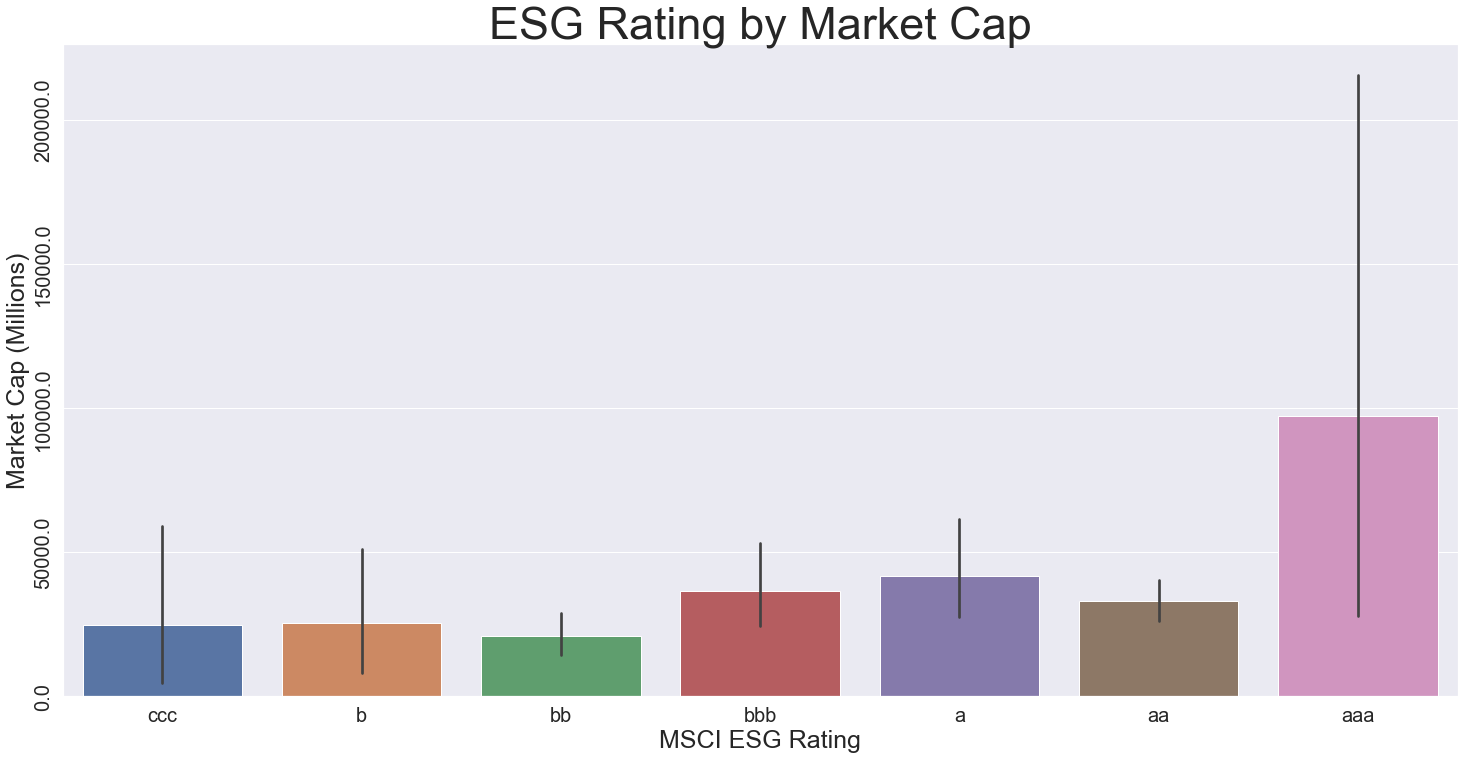

In [19]:
sns.set(rc={'figure.figsize':(25,12)})

ax = sns.barplot(x="overall_esg_rating", y="market_cap", data=df, order=['ccc','b','bb','bbb','a','aa','aaa'])

plt.title('ESG Rating by Market Cap', fontsize=45, pad=5)
plt.ylabel('Market Cap (Millions)', fontsize=25)
plt.xlabel('MSCI ESG Rating', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=90, va='center')

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
;

''

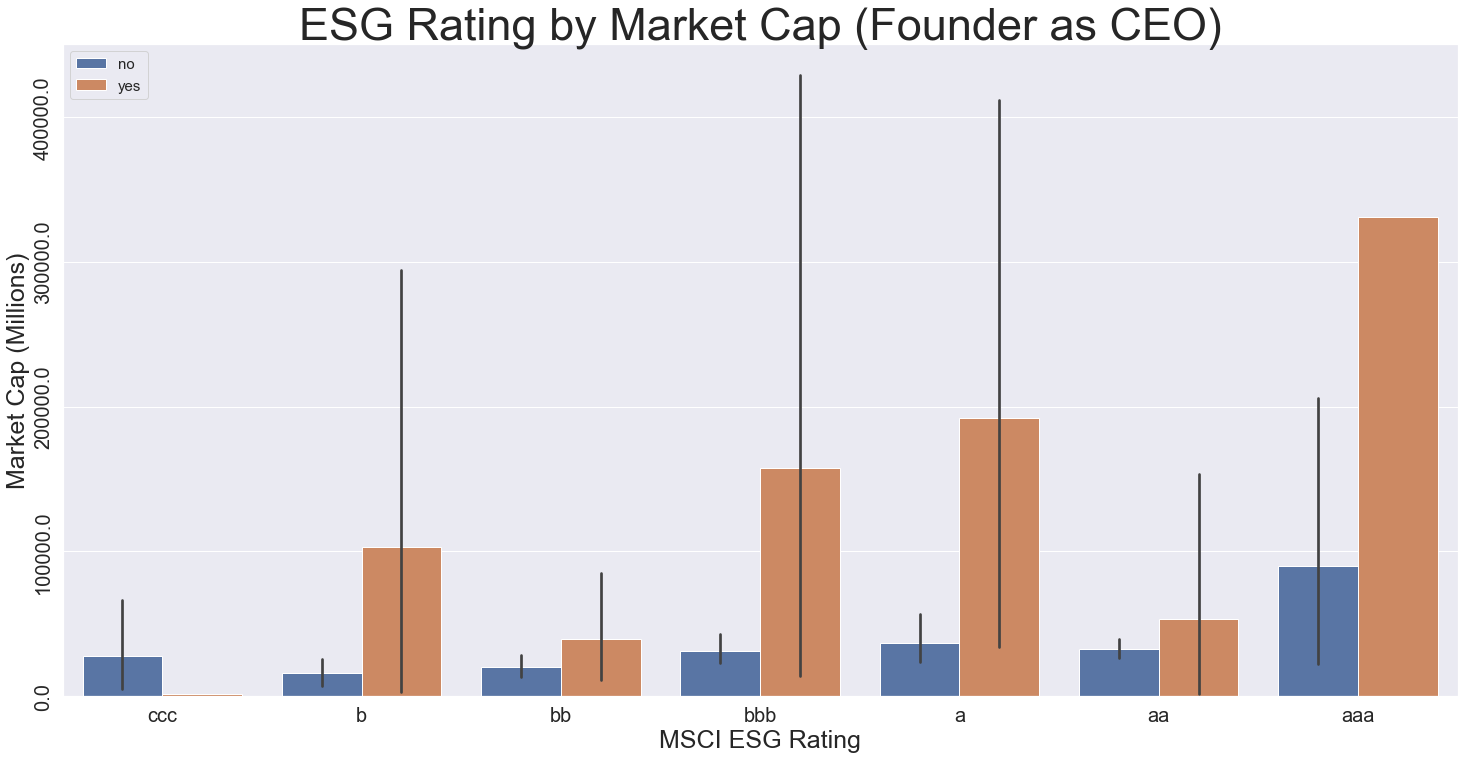

In [20]:
sns.set(rc={'figure.figsize':(25,12)})

ax = sns.barplot(x="overall_esg_rating", y="market_cap", hue="ceo_founder", data=df, order=['ccc','b','bb','bbb','a','aa','aaa'])

plt.title('ESG Rating by Market Cap (Founder as CEO)', fontsize=45, pad=5)
plt.ylabel('Market Cap (Millions)', fontsize=25)
plt.xlabel('MSCI ESG Rating', fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=90, va='center')

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

ax.legend(loc='upper left', fontsize=15)
;

corporations that still have an initial founder both tend to have a higher valuation, and have better performance on ESG Ratings. This could potentially be due to a stronger sense of ownership/accountability with founders vs hired CEOs.

In [21]:
df.sort_values(by='overall_esg_rating', ascending=False)

df.shape

(1098, 18)

In [22]:
df.head()

,company,rank,revenue,profit,num_of_employees,sector,subsector,state,newcomer,ceo_founder,ceo_woman,profitable,market_cap,overall_esg_rating,overall_esg_score,environmental_score,social_score,governance_score
0,walmart,1,5.239640e+11,1.488100e+10,2200000,retailing,hypermarkets_super_centers,ar,no,no,no,yes,4.116900e+11,bbb,4.9,8.0,4.1,3.3
1,amazon,2,2.805220e+11,1.158800e+10,798000,retailing,internet_direct_marketing_retail,wa,no,yes,no,yes,1.637405e+12,bbb,5.6,5.5,5.0,4.7
3,exxon_mobil,3,2.649380e+11,1.434000e+10,74900,energy,integrated_oil_gas,tx,no,no,no,yes,1.779230e+11,bbb,4.6,4.1,6.1,4.4
5,apple,4,2.601740e+11,5.525600e+10,137000,technology,technology_hardware_storage_peripherals,ca,no,no,no,yes,2.221176e+12,a,6.1,3.8,5.6,3.6
6,cvs_health,5,2.567760e+11,6.634000e+09,290000,health_care,health_care_services,ri,no,no,yes,yes,9.849600e+10,a,5.8,10.0,4.0,5.9


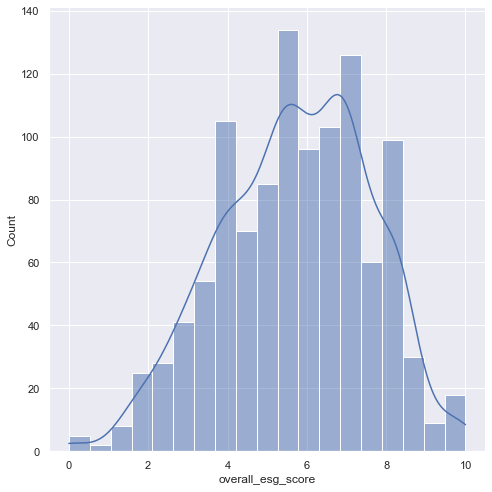

In [23]:
sns.set_theme(style="darkgrid")

sns.displot(
    df, x="overall_esg_score", height=7, facet_kws=dict(margin_titles=True), kde=True
);

Relatively normalized distribution for scoring

In [24]:
sector_list = list(set(df.sector))

In [25]:
sector_list

['food_drug_stores',
 'materials',
 'retailing',
 'transportation',
 'wholesalers',
 'media',
 'business_services',
 'chemicals',
 'technology',
 'health_care',
 'financials',
 'engineering_construction',
 'motor_vehicles_parts',
 'aerospace_defense',
 'household_products',
 'hotels_restaurants_leisure',
 'telecommunications',
 'apparel',
 'food_beverages_tobacco',
 'energy',
 'industrials']

## Begin Eval on ESG Info

In [26]:
# I'll need to decide whether to include the ESG ranking scores, or if that will be too much of a giveaway
numeric_columns = ['overall_esg_score', 'environmental_score', 'social_score', 'governance_score', "rank", "revenue", "profit", "num_of_employees", 'market_cap']

In [27]:
corr_num = df[numeric_columns].copy()

In [28]:
corr_num = corr_num.corr()

### Using this Correlation Matrix

''

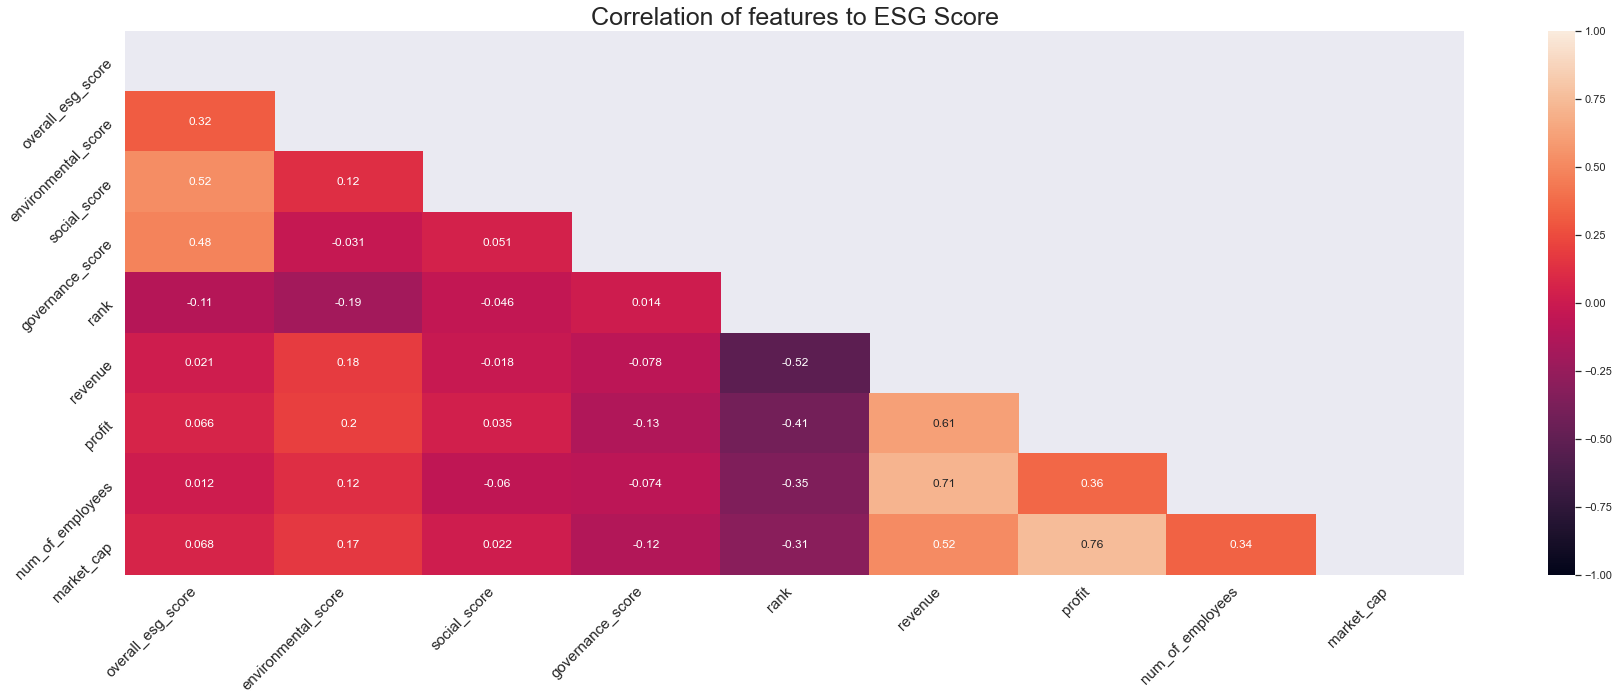

In [29]:
corr = round(corr_num,3)
sns.set(rc = {'figure.figsize':(30,10)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 15, rotation = 45, ha='right')
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 15, rotation = 45)

plt.title('Correlation of features to ESG Score', fontsize = 25,)

;

Hmmm, not looking good - the numeric columns don't seem to have a strong correlation to the overall ESG score. Even the env, social, and governance score columns don't seem to have a large correlation to overall score, likely due to MSCI's weighting for different sectors.

# Initial Data and Feature Engineering

# Add Additional Target Variable - reduced to 3 classes

In MSCI's Framework, companies can be broken down into 3 groups based on their ESG Rating:


-Laggard
 - A company lagging its industry based on its high exposure and failure to manage significant ESG risks
 
 
-Average
 - A company with a mixed or unexceptional track record of managing the most significant ESG risks and opportunities relative to industry peers
 
 
-Leader
 - A company leading its industry in managing the most significant ESG risks and opportunities

In [30]:
def classify(value):
    if value >= 2.857 and value < 7.143:
        return "Average"
    elif value >= 7.143:
        return "Leader"
    else:
        return "Laggard"

In [31]:
df['classification'] = df.apply(lambda row: classify(row['overall_esg_score']), axis = 1)

In [32]:
median_e = df.environmental_score.median()
median_s = df.social_score.median()
median_g = df.governance_score.median()

In [33]:
df['env_class'] = df['environmental_score'] > median_e
df['soc_class'] = df['social_score'] > median_s
df['gov_class'] = df['governance_score'] > median_g

### ANOVA on market cap for E, S, and G

In [34]:
df.head()

,company,rank,revenue,profit,num_of_employees,sector,subsector,state,newcomer,ceo_founder,...,market_cap,overall_esg_rating,overall_esg_score,environmental_score,social_score,governance_score,classification,env_class,soc_class,gov_class
0,walmart,1,5.239640e+11,1.488100e+10,2200000,retailing,hypermarkets_super_centers,ar,no,no,...,4.116900e+11,bbb,4.9,8.0,4.1,3.3,Average,True,False,False
1,amazon,2,2.805220e+11,1.158800e+10,798000,retailing,internet_direct_marketing_retail,wa,no,yes,...,1.637405e+12,bbb,5.6,5.5,5.0,4.7,Average,True,True,False
3,exxon_mobil,3,2.649380e+11,1.434000e+10,74900,energy,integrated_oil_gas,tx,no,no,...,1.779230e+11,bbb,4.6,4.1,6.1,4.4,Average,False,True,False
5,apple,4,2.601740e+11,5.525600e+10,137000,technology,technology_hardware_storage_peripherals,ca,no,no,...,2.221176e+12,a,6.1,3.8,5.6,3.6,Average,False,True,False
6,cvs_health,5,2.567760e+11,6.634000e+09,290000,health_care,health_care_services,ri,no,no,...,9.849600e+10,a,5.8,10.0,4.0,5.9,Average,True,False,True


In [35]:
df.columns

Index(['company', 'rank', 'revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'newcomer', 'ceo_founder', 'ceo_woman',
       'profitable', 'market_cap', 'overall_esg_rating', 'overall_esg_score',
       'environmental_score', 'social_score', 'governance_score',
       'classification', 'env_class', 'soc_class', 'gov_class'],
      dtype='object')

In [36]:
formula = 'market_cap ~ C(overall_esg_rating) + overall_esg_score + environmental_score + social_score + governance_score'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                             sum_sq      df          F        PR(>F)
C(overall_esg_rating)  1.060736e+23     6.0   1.227051  2.896053e-01
overall_esg_score      3.908913e+22     1.0   2.713080  9.981767e-02
environmental_score    2.069413e+23     1.0  14.363286  1.589876e-04
social_score           4.711716e+22     1.0   3.270286  7.082158e-02
governance_score       3.892664e+23     1.0  27.018019  2.406588e-07
Residual               1.566112e+25  1087.0        NaN           NaN


In [37]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             market_cap   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     6.749
Date:                Fri, 26 Aug 2022   Prob (F-statistic):           2.96e-10
Time:                        10:15:06   Log-Likelihood:                -29564.
No. Observations:                1098   AIC:                         5.915e+04
Df Residuals:                    1087   BIC:                         5.920e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     4.883e+10   6.07e+10      0.804      0.422   -7.04e+10    1.68e+11
C(overall_esg_rating)[T.aa]  -2.191e+10   1.61e+10     -1.361      0.174   -5.35e+10    9.67e+09
C(overall_esg_rating)[T.aaa]  2.188e+10    3.4e+10      0.644      0.520   -4.48e+10    8.86e+10
C(overall_esg_rating)[T.b]    2.441e+10   4.11e+10      0.594      0.553   -5.62e+10    1.05e+11
C(overall_esg_rating)[T.bb]   5.643e+09   2.77e+10      0.204      0.839   -4.87e+10       6e+10
C(overall_esg_rating)[T.bbb]   8.92e+09   1.58e+10      0.563      0.573   -2.22e+10       4e+10
C(overall_esg_rating)[T.ccc]   6.52e+09   6.67e+10      0.098      0.922   -1.24e+11    1.37e+11
overall_esg_score              1.46e+10   8.87e+09      1.647      0.100   -2.79e+09     3.2e+10
environmental_score           6.322e+09   1.67e+09      3.790      0.000    3.05e+09    9.59e+09
social_score                 -5.484e+09   3.03e+09     -1.808      0.071   -1.14e+10    4.66e+08
governance_score             -1.983e+10   3.82e+09     -5.198      0.000   -2.73e+10   -1.23e+10
==============================================================================
Omnibus:                     1875.280   Durbin-Watson:                   1.610
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1228165.700
Skew:                          11.178   Prob(JB):                         0.00
Kurtosis:                     165.313   Cond. No.                         304.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Look at financials on a per-employee basis (indicator of productivity)

In [38]:
df['profit_per_capita'] = df['profit'] / df['num_of_employees']
df['rev_per_capita'] = df['revenue'] / df['num_of_employees']
df['marcap_per_capita'] = df['market_cap'] / df['num_of_employees']

In [39]:
numeric_columns_2 = ['overall_esg_score', 'environmental_score', 'social_score', 'governance_score',
                     "rank", "revenue", "profit", "num_of_employees", 'market_cap', 'profit_per_capita',
                     'rev_per_capita', 'marcap_per_capita']

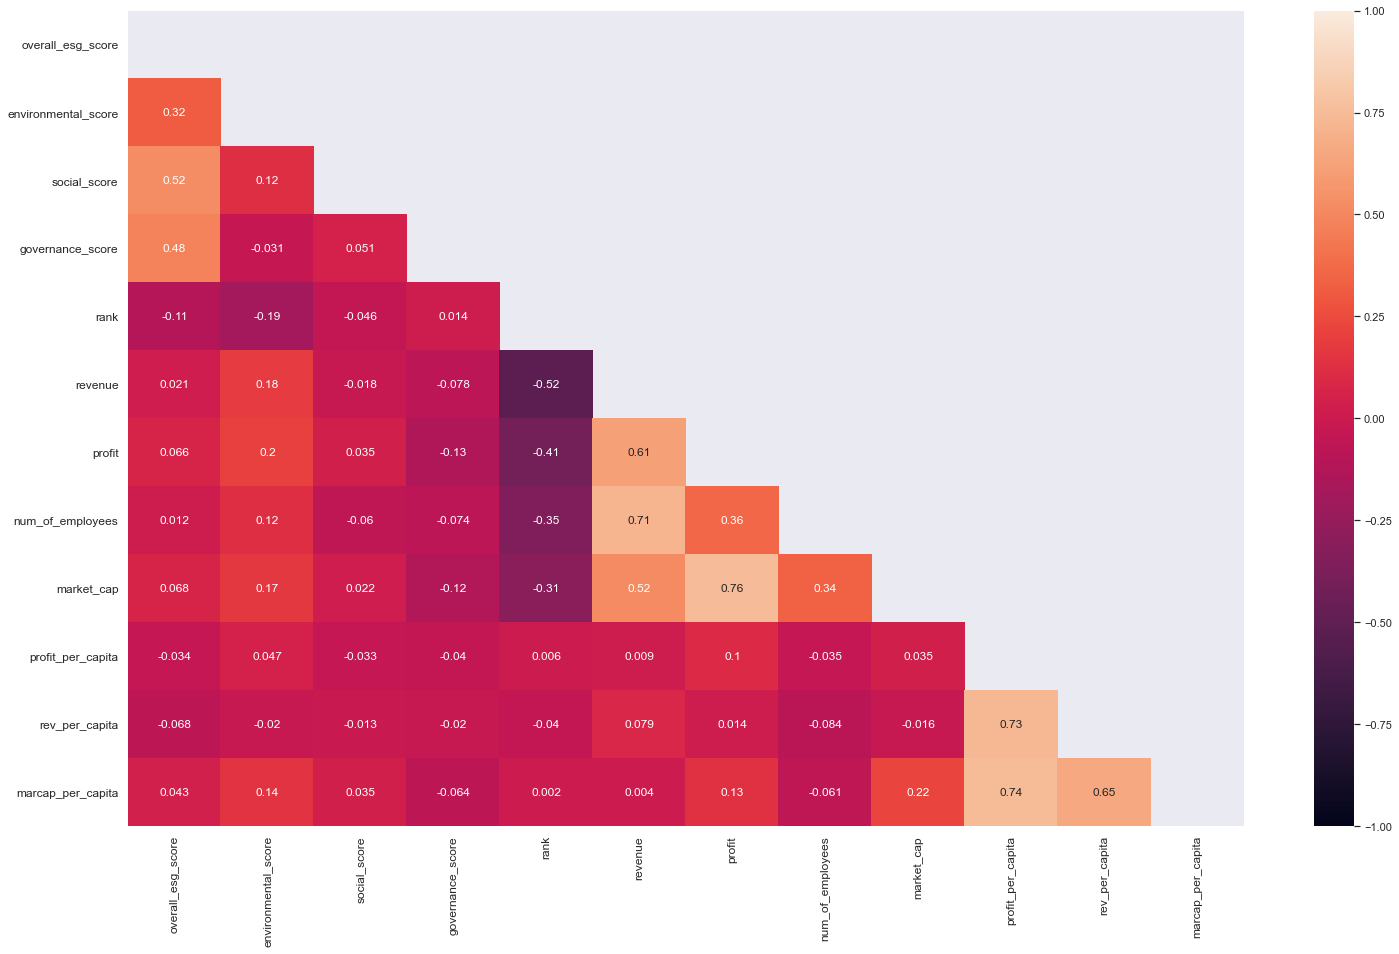

In [40]:
corr_num = df[numeric_columns_2].copy()

corr_num = corr_num.corr()

corr = round(corr_num,3)
sns.set(rc = {'figure.figsize':(25,15)})
mask = np.triu(np.ones_like(corr, dtype=bool))
res = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12);

Now let's try weighting financials by their E, S and G scores

In [41]:
df['profit_env'] = df['profit'] * (df['environmental_score'] / 10)
df['profit_soc'] = df['profit'] * (df['social_score'] / 10)
df['profit_gov'] = df['profit'] * (df['governance_score'] / 10)
df['revenue_env'] = df['revenue'] * (df['environmental_score'] / 10)
df['revenue_soc'] = df['revenue'] * (df['social_score'] / 10)
df['revenue_gov'] = df['revenue'] * (df['governance_score'] / 10)
df['marcap_env'] = df['market_cap'] * (df['environmental_score'] / 10)
df['marcap_soc'] = df['market_cap'] * (df['social_score'] / 10)
df['marcap_gov'] = df['market_cap'] * (df['governance_score'] / 10)

In [42]:
numeric_columns_3 = ['overall_esg_score', 'environmental_score', 'social_score', 'governance_score',
                     "rank", "revenue", "profit", "num_of_employees", 'market_cap', 'profit_per_capita',
                     'rev_per_capita', 'marcap_per_capita', 'profit_env', 'profit_soc', 'profit_gov',
                     'revenue_env', 'revenue_soc','revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov']

Damn, none of these have a strong relationship either...

In [43]:
df['esg_score_int'] = round(df['overall_esg_score'])

In [44]:
df.overall_esg_score.value_counts()

7.00    42
5.70    36
6.50    35
5.60    29
7.10    29
        ..
4.25     1
1.10     1
9.30     1
0.70     1
8.90     1
Name: overall_esg_score, Length: 96, dtype: int64

In [45]:
df.esg_score_int.value_counts()

6.0     234
7.0     206
5.0     165
8.0     156
4.0     155
3.0      84
2.0      51
9.0      20
10.0     18
0.0       5
1.0       4
Name: esg_score_int, dtype: int64

''

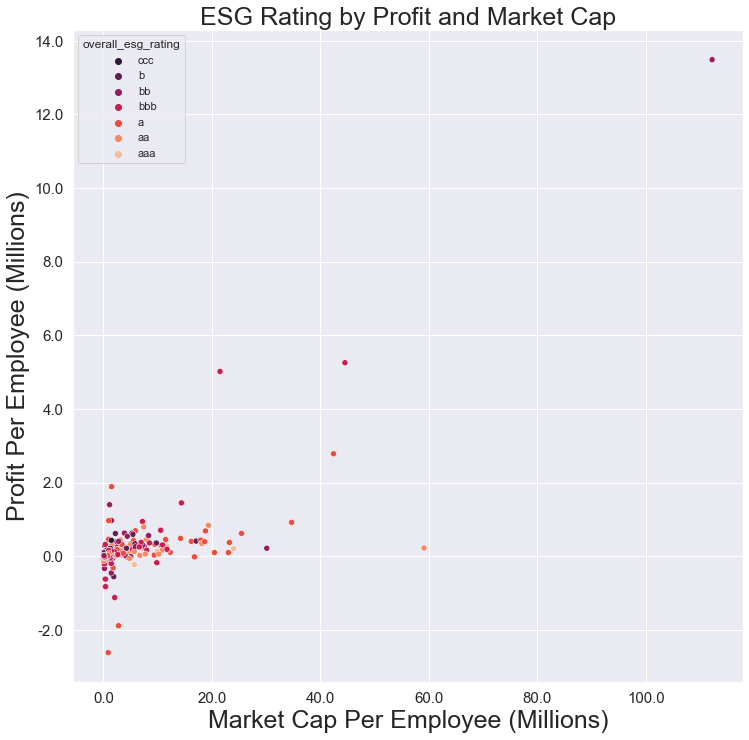

In [46]:
sns.set(rc={'figure.figsize':(12,12)})

sns.set_theme(style="darkgrid")

hue_order = ['ccc', 'b', 'bb', 'bbb', 'a', 'aa', 'aaa']

ax = sns.scatterplot(
    data = df, x="marcap_per_capita", y="profit_per_capita", hue='overall_esg_rating', hue_order=hue_order, palette="rocket")

plt.ticklabel_format(style='plain')

plt.title('ESG Rating by Profit and Market Cap', fontsize=25, pad=5)
plt.ylabel('Profit Per Employee (Millions)', fontsize=25)
plt.xlabel('Market Cap Per Employee (Millions)', fontsize=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
;

# Initial Modeling

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 0 to 1282
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1098 non-null   object 
 1   rank                 1098 non-null   int64  
 2   revenue              1098 non-null   float64
 3   profit               1098 non-null   float64
 4   num_of_employees     1098 non-null   int64  
 5   sector               1098 non-null   object 
 6   subsector            1092 non-null   object 
 7   state                1098 non-null   object 
 8   newcomer             593 non-null    object 
 9   ceo_founder          1098 non-null   object 
 10  ceo_woman            1098 non-null   object 
 11  profitable           1098 non-null   object 
 12  market_cap           1098 non-null   float64
 13  overall_esg_rating   1098 non-null   object 
 14  overall_esg_score    1098 non-null   float64
 15  environmental_score  1098 non-null   f

In [48]:
df.columns

Index(['company', 'rank', 'revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'newcomer', 'ceo_founder', 'ceo_woman',
       'profitable', 'market_cap', 'overall_esg_rating', 'overall_esg_score',
       'environmental_score', 'social_score', 'governance_score',
       'classification', 'env_class', 'soc_class', 'gov_class',
       'profit_per_capita', 'rev_per_capita', 'marcap_per_capita',
       'profit_env', 'profit_soc', 'profit_gov', 'revenue_env', 'revenue_soc',
       'revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov',
       'esg_score_int'],
      dtype='object')

In [49]:
relevant_columns_all = ['environmental_score', 'social_score', 'governance_score',
  'revenue', 'profit', 'num_of_employees', 'market_cap', 'profit_per_capita',
  'rev_per_capita', 'marcap_per_capita', 'profit_env', 'profit_soc',
  'profit_gov', 'revenue_env', 'revenue_soc', 'revenue_gov', 'marcap_env',
  'marcap_soc', 'marcap_gov', 'sector', 'subsector', 'state', 'ceo_founder',
  'ceo_woman', 'profitable']

In [50]:
len(relevant_columns_all)

25

In [51]:
relevant_columns_no_esg = ['revenue', 'profit', 'num_of_employees', 'sector',
                      'ceo_founder', 'ceo_woman', 'profitable','market_cap',
                      'profit_per_capita', 'rev_per_capita', 'marcap_per_capita']

In [52]:
relevant_columns_esg_finance = ['revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'ceo_founder', 'ceo_woman', 'profitable',
       'market_cap', 'profit_per_capita', 'rev_per_capita', 'marcap_per_capita',
       'profit_env', 'profit_soc', 'profit_gov', 'revenue_env', 'revenue_soc',
       'revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov']

In [53]:
relevant_columns_esg_explicit = ['revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'ceo_founder', 'ceo_woman', 'profitable',
       'market_cap', 'environmental_score', 'social_score', 'governance_score',
       'profit_per_capita', 'rev_per_capita', 'marcap_per_capita',
       'profit_env', 'profit_soc', 'profit_gov', 'revenue_env', 'revenue_soc',
       'revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov']

Evaluate target variables

In [54]:
df.overall_esg_rating.value_counts()

a      301
bbb    287
aa     208
bb     190
b       71
aaa     32
ccc      9
Name: overall_esg_rating, dtype: int64

In [55]:
X = df[relevant_columns_all]
y = df['overall_esg_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [56]:
#Verify no nulls
X_train.isna().sum()

environmental_score    0
social_score           0
governance_score       0
revenue                0
profit                 0
num_of_employees       0
market_cap             0
profit_per_capita      0
rev_per_capita         0
marcap_per_capita      0
profit_env             0
profit_soc             0
profit_gov             0
revenue_env            0
revenue_soc            0
revenue_gov            0
marcap_env             0
marcap_soc             0
marcap_gov             0
sector                 0
subsector              6
state                  0
ceo_founder            0
ceo_woman              0
profitable             0
dtype: int64

In [57]:
# Use these mini-pipelines to solve for our our ColumnTransformer: numeric and categorical
subpipe_num = Pipeline(steps=[
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(missing_values=None, strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [58]:
numeric_columns_all = ['environmental_score', 'social_score', 'governance_score',
                     "rank", "revenue", "profit", "num_of_employees", 'market_cap', 'profit_per_capita',
                     'rev_per_capita', 'marcap_per_capita', 'profit_env', 'profit_soc', 'profit_gov',
                     'revenue_env', 'revenue_soc','revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov']

In [59]:
cat_columns_all = ['sector', 'subsector', 'state', 'ceo_founder', 'ceo_woman',
                   'profitable']

In [60]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

### Dummy Model Pipe

In [61]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dum', DummyClassifier(strategy="stratified"))
])


In [62]:
dummy_model = dummy_model_pipe.fit(X_train, y_train)

In [63]:
dummy_model.score(X_train, y_train)

0.2284325637910085

In [64]:
dummy_model.score(X_test, y_test)

0.23636363636363636

Hmmm, it works on the overall training and test set, but not yet on the SMOTE Resample set (below)

Below Class taken from lesson 51-workflow_with_pipelines.ipynb

In [65]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [66]:
def scoring(model_pipe, X_train, X_test, y_train, y_test):
    model = model_pipe.fit(X_train, y_train)
    
    # Test Predisctions
    preds = model.predict(X_test)
    
    #Metrics for testing
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted')
    rec = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    
    # Training Results
    model_cv = ModelWithCV(model_pipe, 'train_model', X_train, y_train)
    print(f'Test Data Results:\n',
            f'accuracy - {acc} \n',
            f'precision - {prec} \n',
            f'recall - {rec} \n',
            f'F1 Score - {f1} \n')
    model_cv.print_cv_summary()

In [67]:
dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy_model', X_train, y_train)

<AxesSubplot:title={'center':'CV Results for `dummy_model` Model'}>

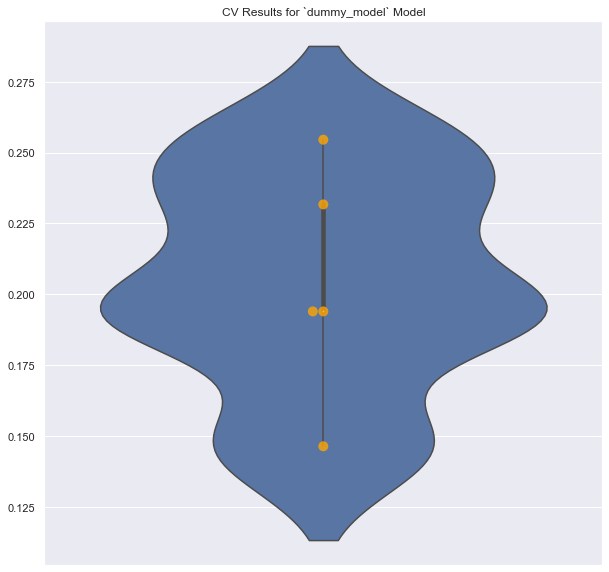

In [68]:
# Use the class with out dummy pipe

fig, ax = plt.subplots(figsize=(10,10))

dummy_pipe.plot_cv(ax)

In [69]:
dummy_pipe.print_cv_summary()

CV Results for `dummy_model` model:
            0.20409 ± 0.03701 accuracy
        


In [70]:
dummy_pipe.cv_mean

0.20409460458240947

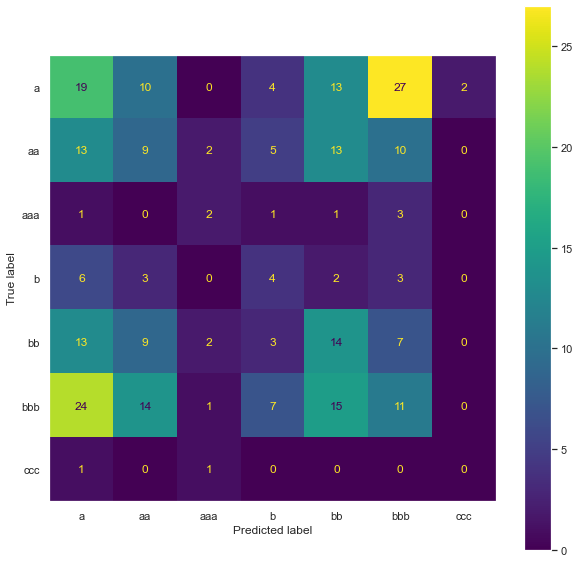

In [71]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(dummy_model, X_test, y_test, ax=ax)

ax.grid(False);

In [72]:
scoring(dummy_model, X_train, X_test, y_train, y_test)

Test Data Results:
 accuracy - 0.23272727272727273 
 precision - 0.23402291897831787 
 recall - 0.23272727272727273 
 F1 Score - 0.2328178956976049 

CV Results for `train_model` model:
            0.20777 ± 0.01844 accuracy
        


## Trying Other Models at the End of the Pipeline

Important note, right now I am using all relavant columns, which includes the comany's respective scores in the E, S, and G categories. This data is weighted depending on sector to generate the overall ESG Rating and score, so it doesn't necessarily introduce leakage, but it also represents data that wouldn't necessarily be initially available.

### Decision Tree

In [73]:
# dtc!


dtc_model_pipe = Pipeline([('ct',CT),('dtc', DecisionTreeClassifier(random_state=42))])

In [74]:
dtc_pipe = ModelWithCV(dtc_model_pipe, 'dtc_model', X_train, y_train)

dtc_pipe.print_cv_summary()

CV Results for `dtc_model` model:
            0.37555 ± 0.04773 accuracy
        


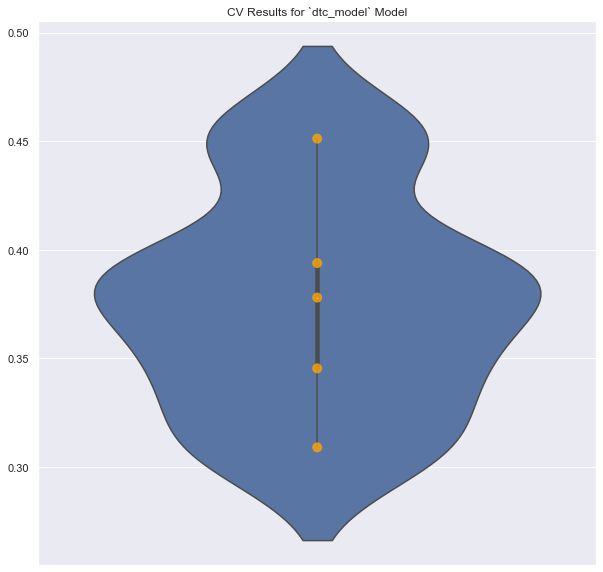

In [75]:
fig, ax = plt.subplots(figsize=(10,10))

dtc_pipe.plot_cv(ax);

In [76]:
dtc_model = dtc_model_pipe.fit(X_train, y_train)

In [77]:
y_test.value_counts()

a      75
bbb    72
aa     52
bb     48
b      18
aaa     8
ccc     2
Name: overall_esg_rating, dtype: int64

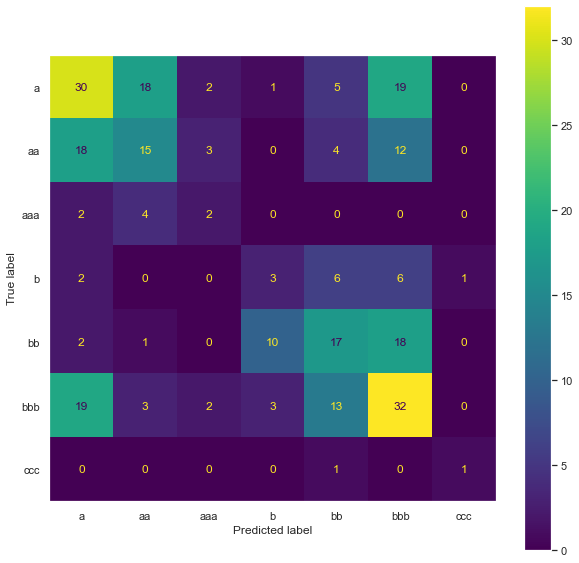

In [78]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(dtc_model, X_test, y_test, ax=ax)

ax.grid(False);

In [79]:
scoring(dtc_model, X_train, X_test, y_train, y_test)

Test Data Results:
 accuracy - 0.36363636363636365 
 precision - 0.3637179835403889 
 recall - 0.36363636363636365 
 F1 Score - 0.36178363775932554 

CV Results for `train_model` model:
            0.37555 ± 0.04773 accuracy
        


### KNN

In [80]:
# knn!


knn_model_pipe = Pipeline([('ct',CT),('knn',KNeighborsClassifier())])

In [81]:
knn_pipe = ModelWithCV(knn_model_pipe, 'knn_model', X_train, y_train)

knn_pipe.print_cv_summary()

CV Results for `knn_model` model:
            0.32809 ± 0.02307 accuracy
        


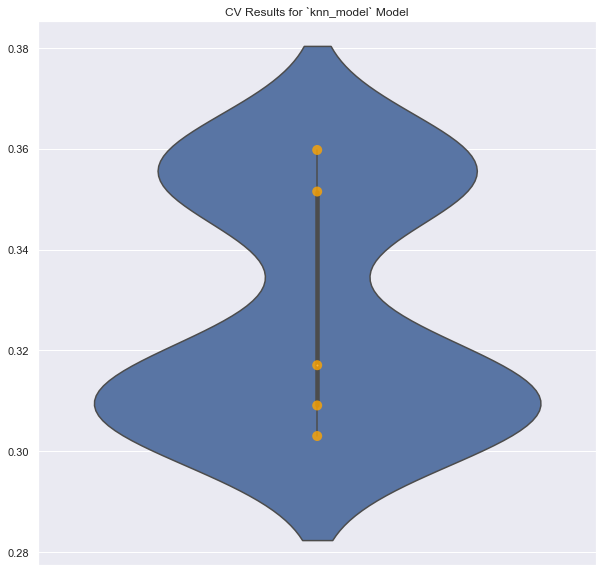

In [82]:
fig, ax = plt.subplots(figsize=(10,10))

knn_pipe.plot_cv(ax);

In [83]:
knn_model = knn_model_pipe.fit(X_train, y_train)

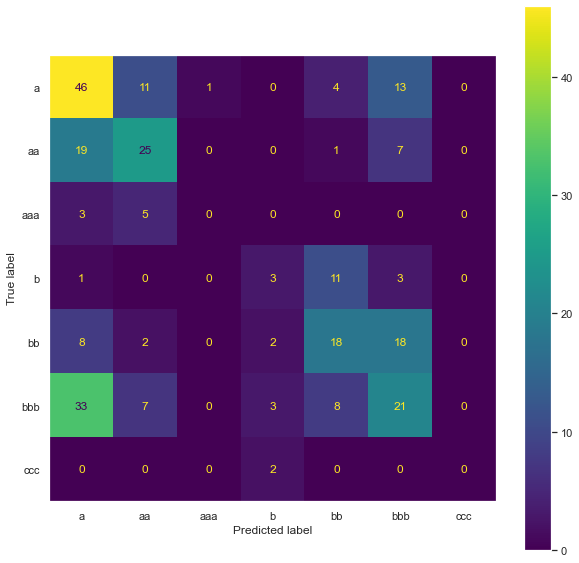

In [84]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(knn_model, X_test, y_test, ax=ax)
ax.grid(False);

In [85]:
scoring(knn_model, X_train, X_test, y_train, y_test)

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.4109090909090909 
 precision - 0.39171695167003084 
 recall - 0.4109090909090909 
 F1 Score - 0.3942247287708218 

CV Results for `train_model` model:
            0.32809 ± 0.02307 accuracy
        


### Random Forest

In [86]:
# rfc!


rfc_model_pipe = Pipeline([('ct',CT),('rfc',RandomForestClassifier(random_state=42))])

In [87]:
rfc_pipe = ModelWithCV(rfc_model_pipe, 'rfc_model', X_train, y_train)

rfc_pipe.print_cv_summary()

CV Results for `rfc_model` model:
            0.40225 ± 0.04089 accuracy
        


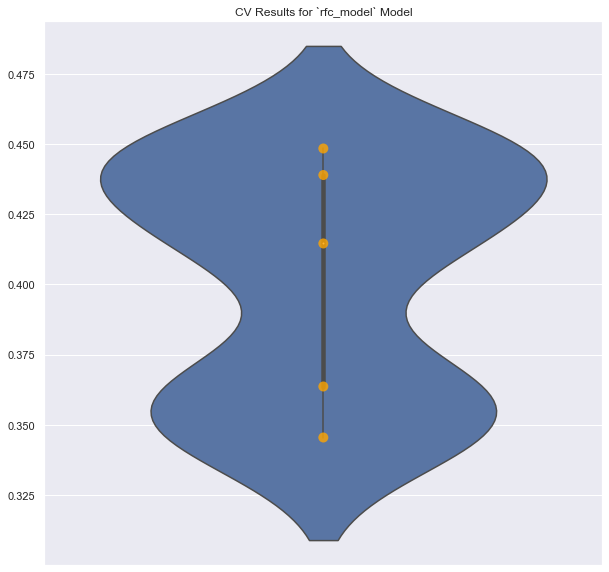

In [88]:
fig, ax = plt.subplots(figsize=(10,10))

rfc_pipe.plot_cv(ax);

In [89]:
rfc_model = rfc_model_pipe.fit(X_train, y_train)

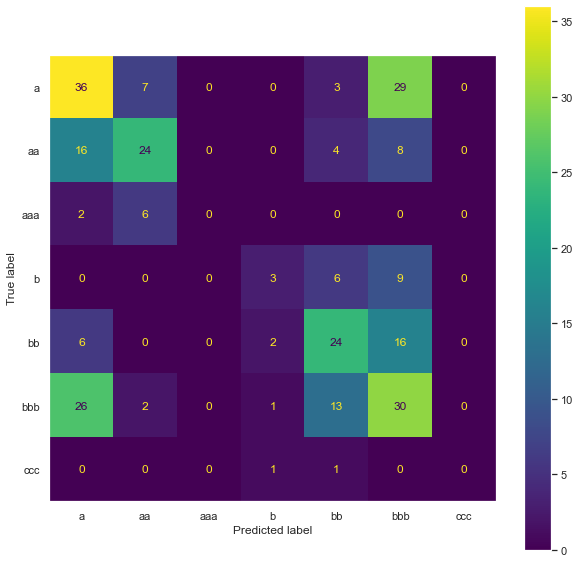

In [90]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(rfc_model, X_test, y_test, ax=ax)
ax.grid(False);

In [91]:
scoring(rfc_model, X_train, X_test, y_train, y_test)

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.4254545454545455 
 precision - 0.4260950207824651 
 recall - 0.4254545454545455 
 F1 Score - 0.417829581042692 

CV Results for `train_model` model:
            0.40225 ± 0.04089 accuracy
        


### Gradient Booster

In [92]:
# gbc!

gbc = GradientBoostingClassifier(random_state=42)

gbc_model_pipe = Pipeline([('ct', CT), ('gbc',gbc)])

In [93]:
gbc_pipe = ModelWithCV(gbc_model_pipe, 'gbc_model', X_train, y_train)

gbc_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.40224 ± 0.02774 accuracy
        


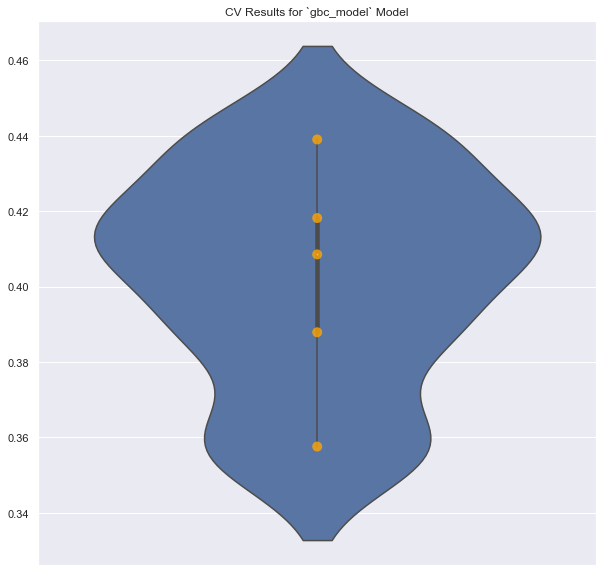

In [94]:
fig, ax = plt.subplots(figsize=(10,10))

gbc_pipe.plot_cv(ax);

In [95]:
gbc_model = gbc_model_pipe.fit(X_train, y_train)

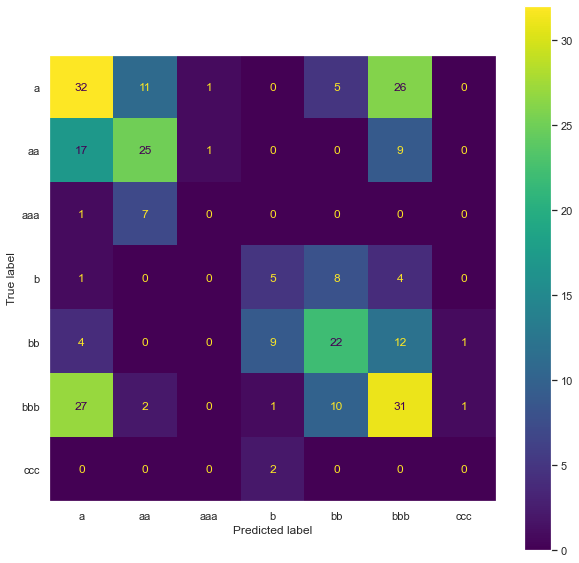

In [96]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(gbc_model, X_test, y_test, ax = ax)
ax.grid(False);

In [97]:
scoring(gbc_model, X_train, X_test, y_train, y_test)

Test Data Results:
 accuracy - 0.41818181818181815 
 precision - 0.4150453748387751 
 recall - 0.41818181818181815 
 F1 Score - 0.41533425333894 

CV Results for `train_model` model:
            0.40224 ± 0.02774 accuracy
        


### XGBoost

In [98]:
# gbc!

xgb = xgboost.XGBClassifier(random_state=42, objective='multi:softmax', num_class=6, disable_default_eval_metric=True, eval_metric='mlogloss', verbosity=0)

xgb_model_pipe = Pipeline([('ct', CT), ('xgb',xgb)])

In [99]:
xgb_pipe = ModelWithCV(xgb_model_pipe, 'gbc_model', X_train, y_train)

xgb_pipe.print_cv_summary()

CV Results for `gbc_model` model:
            0.38157 ± 0.02973 accuracy
        


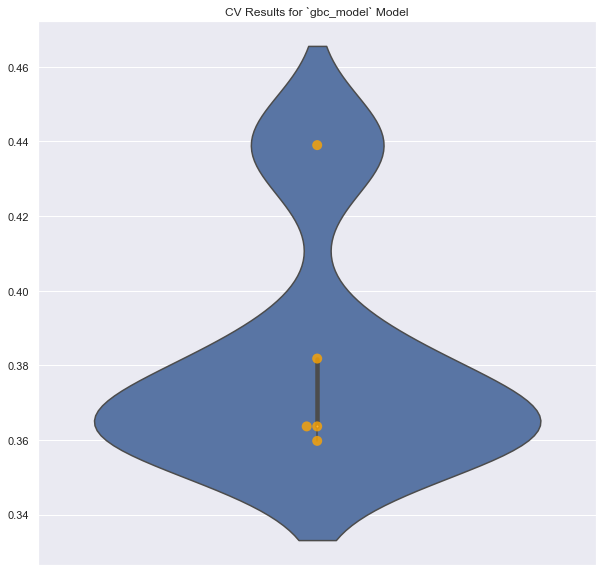

In [100]:
fig, ax = plt.subplots(figsize=(10,10))

xgb_pipe.plot_cv(ax);

In [101]:
xgb_model = xgb_model_pipe.fit(X_train, y_train)

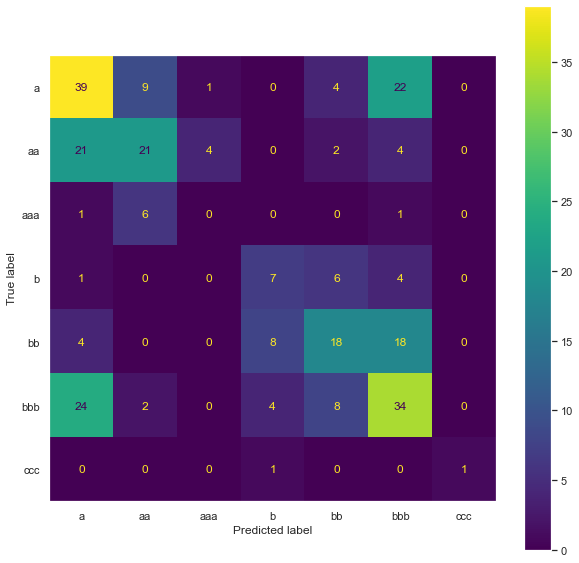

In [102]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(xgb_model, X_test, y_test, ax = ax)

ax.grid(False);

In [103]:
scoring(xgb_model, X_train, X_test, y_train, y_test)

Test Data Results:
 accuracy - 0.43636363636363634 
 precision - 0.44279149132414825 
 recall - 0.43636363636363634 
 F1 Score - 0.4340590706615324 

CV Results for `train_model` model:
            0.38157 ± 0.02973 accuracy
        


### ADABoost

In [104]:
# gbc!

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=100, random_state=42)

ada_model_pipe = Pipeline([('ct', CT), ('ada',ada)])

In [105]:
ada_pipe = ModelWithCV(ada_model_pipe, 'ada_model', X_train, y_train)

ada_pipe.print_cv_summary()

CV Results for `ada_model` model:
            0.35601 ± 0.02725 accuracy
        


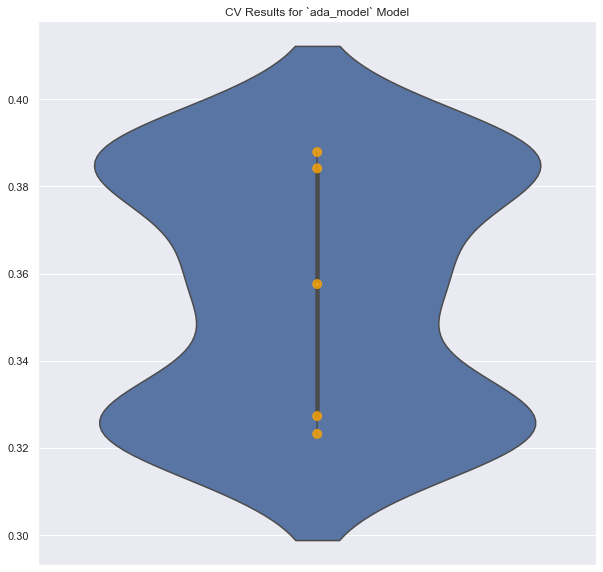

In [106]:
fig, ax = plt.subplots(figsize=(10,10))

ada_pipe.plot_cv(ax);

In [107]:
ada_model = ada_model_pipe.fit(X_train, y_train)

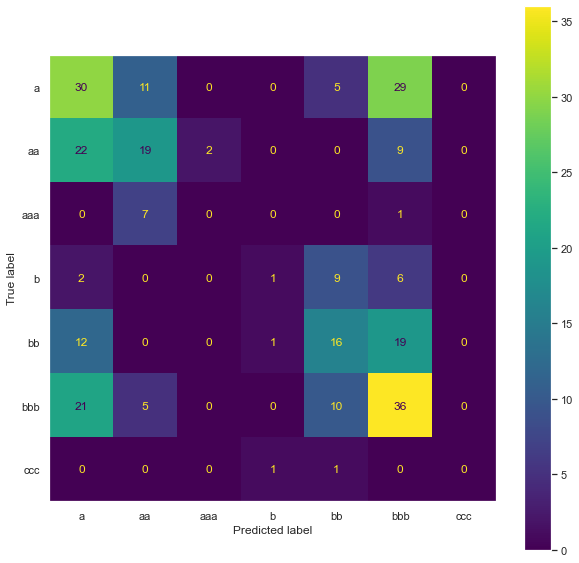

In [108]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(ada_model, X_test, y_test, ax = ax)
ax.grid(False);

In [109]:
scoring(ada_model, X_train, X_test, y_train, y_test)

/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.3709090909090909 
 precision - 0.3637730392959998 
 recall - 0.3709090909090909 
 F1 Score - 0.3560410979557136 

CV Results for `train_model` model:
            0.35601 ± 0.02725 accuracy
        


### Complement naive Bayes - doesn't work unless I transform into frequency counts for each of the features

In [110]:
# # gbc!

# cnb = ComplementNB()

# cnb_model_pipe = Pipeline([('ct', CT), ('cnb',cnb)])

In [111]:
# cnb_pipe = ModelWithCV(cnb_model_pipe, 'cnb_model', X_train, y_train)

# cnb_pipe.print_cv_summary()

In [112]:
# fig, ax = plt.subplots(figsize=(10,10))

# cnb_pipe.plot_cv(ax);

In [113]:
# cnb_model = cnb_model_pipe.fit(X_train, y_train)

In [114]:
# fig, ax = plt.subplots(figsize=(10,10))

# plot_confusion_matrix(cnb_model, X_test, y_test, ax = ax)

In [115]:
# scoring(cnb_model, X_train, X_test, y_train, y_test)

In [116]:
print('Dummy:\n',
      scoring(dummy_model, X_train, X_test, y_train, y_test),
     'Decision Tree:\n',
      scoring(dtc_model, X_train, X_test, y_train, y_test),
     'KNN:\n',
      scoring(knn_model, X_train, X_test, y_train, y_test),
     'RandomForest:\n',
      scoring(rfc_model, X_train, X_test, y_train, y_test),
     'Gradient Boosted:\n',
      scoring(gbc_model, X_train, X_test, y_train, y_test),
     'XGBoost:\n',
      scoring(xgb_model, X_train, X_test, y_train, y_test),
     'ADABoost:\n',
      scoring(ada_model, X_train, X_test, y_train, y_test))

Test Data Results:
 accuracy - 0.20363636363636364 
 precision - 0.20951183135626805 
 recall - 0.20363636363636364 
 F1 Score - 0.2060923459848009 

CV Results for `train_model` model:
            0.21142 ± 0.01507 accuracy
        
Test Data Results:
 accuracy - 0.36363636363636365 
 precision - 0.3637179835403889 
 recall - 0.36363636363636365 
 F1 Score - 0.36178363775932554 

CV Results for `train_model` model:
            0.37555 ± 0.04773 accuracy
        


/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.4109090909090909 
 precision - 0.39171695167003084 
 recall - 0.4109090909090909 
 F1 Score - 0.3942247287708218 

CV Results for `train_model` model:
            0.32809 ± 0.02307 accuracy
        


/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.4254545454545455 
 precision - 0.4260950207824651 
 recall - 0.4254545454545455 
 F1 Score - 0.417829581042692 

CV Results for `train_model` model:
            0.40225 ± 0.04089 accuracy
        
Test Data Results:
 accuracy - 0.41818181818181815 
 precision - 0.4150453748387751 
 recall - 0.41818181818181815 
 F1 Score - 0.41533425333894 

CV Results for `train_model` model:
            0.40224 ± 0.02774 accuracy
        
Test Data Results:
 accuracy - 0.43636363636363634 
 precision - 0.44279149132414825 
 recall - 0.43636363636363634 
 F1 Score - 0.4340590706615324 

CV Results for `train_model` model:
            0.38157 ± 0.02973 accuracy
        


/Users/charlielosche/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Data Results:
 accuracy - 0.3709090909090909 
 precision - 0.3637730392959998 
 recall - 0.3709090909090909 
 F1 Score - 0.3560410979557136 

CV Results for `train_model` model:
            0.35601 ± 0.02725 accuracy
        
Dummy:
 None Decision Tree:
 None KNN:
 None RandomForest:
 None Gradient Boosted:
 None XGBoost:
 None ADABoost:
 None


Overall, the XGBoost model worked the best out of all of the potential models used above. I could have done initial work to use Naive Bayes, but given the time crunch decided not to.

# Grid Search/Parameter Tuning on XGBoost Model

In [117]:
# xgb_model

In [118]:
# params = {}
# params['ct__subpipe_num__ss'] = [StandardScaler(), MinMaxScaler(), RobustScaler()]
# params['xgb__booster'] = ['gbtree', 'dart']
# params['xgb__max_depth'] = [1,5,7,10]
# params['xgb__objective'] = ['multi:softmax']
# params['xgb__eval_metric'] = ['merror', 'mlogloss']

In [119]:
# params

In [120]:
# gs = GridSearchCV(xgb_model_pipe,params, cv=5, verbose=1)

In [121]:
# gs.fit(X_train, y_train)

In [122]:
# gs.best_params_

In [123]:
# gs.score(X_train, y_train)

In [124]:
# gs.cv_results_['mean_test_score'].mean()

In [125]:
# gs.score(X_test, y_test)

In [126]:
y2 = df['classification']

In [127]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, stratify=y, test_size=0.25, random_state=42)

In [128]:
dummy_model_2 = dummy_model_pipe.fit(X_train2, y_train2)

In [129]:
dtc_model_2 = dtc_model_pipe.fit(X_train2, y_train2)

In [130]:
knn_model_2 = knn_model_pipe.fit(X_train2, y_train2)

In [131]:
rfc_model_2 = rfc_model_pipe.fit(X_train2, y_train2)

In [132]:
gbc_model_2 = gbc_model_pipe.fit(X_train2, y_train2)

In [133]:
xgb_model_2 = xgb_model_pipe.fit(X_train2, y_train2)

In [134]:
ada_model_2 = ada_model_pipe.fit(X_train2, y_train2)

In [135]:
print(scoring(dummy_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(dtc_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(knn_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(rfc_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(gbc_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(xgb_model_2, X_train2, X_test2, y_train2, y_test2),
      '\n',
      scoring(ada_model_2, X_train2, X_test2, y_train2, y_test2))

Test Data Results:
 accuracy - 0.5963636363636363 
 precision - 0.5755081247255162 
 recall - 0.5963636363636363 
 F1 Score - 0.5850309998506814 

CV Results for `train_model` model:
            0.54191 ± 0.01854 accuracy
        
Test Data Results:
 accuracy - 0.6763636363636364 
 precision - 0.6877556843658539 
 recall - 0.6763636363636364 
 F1 Score - 0.6813567690132144 

CV Results for `train_model` model:
            0.69744 ± 0.03431 accuracy
        
Test Data Results:
 accuracy - 0.7745454545454545 
 precision - 0.7820543093270366 
 recall - 0.7745454545454545 
 F1 Score - 0.7431771963819866 

CV Results for `train_model` model:
            0.73633 ± 0.00994 accuracy
        
Test Data Results:
 accuracy - 0.7563636363636363 
 precision - 0.7940803382663848 
 recall - 0.7563636363636363 
 F1 Score - 0.6915235107636641 

CV Results for `train_model` model:
            0.75339 ± 0.01917 accuracy
        
Test Data Results:
 accuracy - 0.7490909090909091 
 precision - 0.7323973323

## New GridSearch for XGB (Still Best Model)

The grisearch will run, but it is commented out to save memory

In [136]:
# params = {}
# params['ct__subpipe_num__ss'] = [StandardScaler(), MinMaxScaler(), RobustScaler()]
# params['xgb__eta'] = [0.1, 0.3, 0.5]
# params['xgb__booster'] = ['gbtree', 'dart']
# params['xgb__max_depth'] = [1,3,5,7,9,11,13,15]
# params['xgb__objective'] = ['multi:softmax']
# params['xgb__eval_metric'] = ['merror', 'mlogloss']

In [137]:
# params

In [138]:
# gs2 = GridSearchCV(xgb_model_pipe,params, cv=10, verbose=1)

In [139]:
# gs2.fit(X_train2, y_train2)

In [140]:
# gs2.best_params_

In [141]:
# gs2.score(X_train2, y_train2)

In [142]:
# gs2.cv_results_['mean_test_score'].mean()

In [143]:
# gs2.score(X_test2, y_test2)

# Final Model - all features

In [144]:
xgb_final_all = xgboost.XGBClassifier(random_state=42, objective='multi:softmax', num_class=6,
                                  max_depth=3, eta=0.15, disable_default_eval_metric=True,
                                  eval_metric='merror', verbosity=1, booster='gbtree')

xgb_final_all_model_pipe = Pipeline([('ct', CT), ('xgb_final_all',xgb_final_all)])

In [145]:
final_model_all = xgb_final_all_model_pipe.fit(X_train2, y_train2)

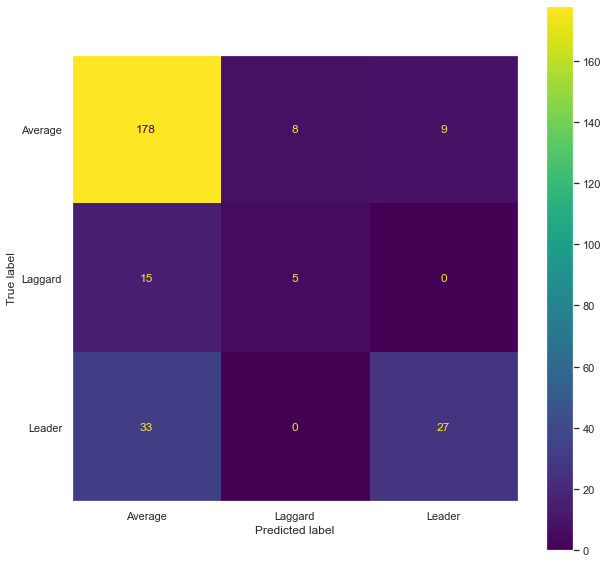

In [146]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(final_model_all, X_test2, y_test2, ax = ax)

ax.grid(False);

In [147]:
scoring(final_model_all, X_train2, X_test2, y_train2, y_test2)

Test Data Results:
 accuracy - 0.7636363636363637 
 precision - 0.7500959217773376 
 recall - 0.7636363636363637 
 F1 Score - 0.7443771552711306 

CV Results for `train_model` model:
            0.77037 ± 0.03573 accuracy
        


In [148]:
xgb_final_all = xgboost.XGBClassifier(random_state=42, objective='multi:softmax', num_class=6,
                                  max_depth=3, eta=0.15, disable_default_eval_metric=True,
                                  eval_metric='merror', verbosity=1, booster='gbtree')

xgb_final_all_model_pipe = Pipeline([('ct', CT), ('xgb_final_all',xgb_final_all)])

In [149]:
final_model_all = xgb_final_all_model_pipe.fit(X_train2, y_train2)

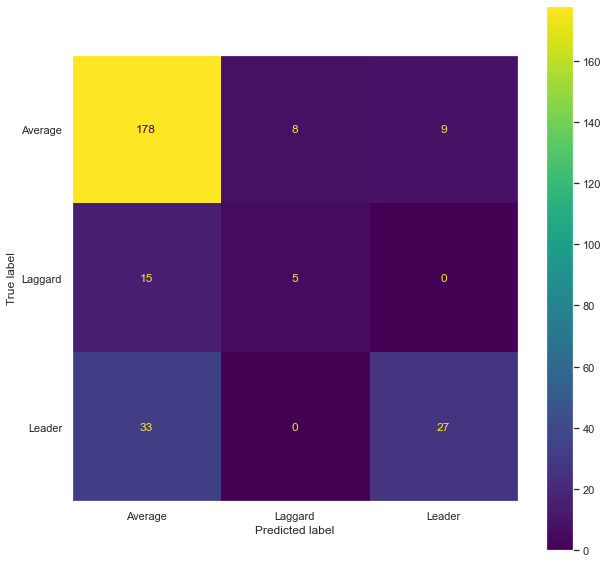

In [150]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(final_model_all, X_test2, y_test2, ax = ax)

ax.grid(False);

In [151]:
scoring(final_model_all, X_train2, X_test2, y_train2, y_test2)

Test Data Results:
 accuracy - 0.7636363636363637 
 precision - 0.7500959217773376 
 recall - 0.7636363636363637 
 F1 Score - 0.7443771552711306 

CV Results for `train_model` model:
            0.77037 ± 0.03573 accuracy
        


look at total dataset (impact of increased data)

In [152]:
final_model_all_tot = xgb_final_all_model_pipe.fit(X, y2)

In [153]:
final_model_all_tot.score(X, y2)

0.9453551912568307

In [154]:
y_hat = final_model_all_tot.predict(X)

In [155]:
print(f"""
Our final model's accuracy on the overall dataset is {round(accuracy_score(y2, y_hat), 5)}. \n
Our final model's recall on the overall dataset is {round(recall_score(y2, y_hat, average='weighted'), 5)} \n
Our final model's precision on the overall dataset is {round(precision_score(y2, y_hat, average='weighted'), 5)} \n
Our final model's f1-score on the overall datasetoverall datasety_hat = final_model.predict(X_test) is {round(f1_score(y2, y_hat, average='weighted'), 5)}.
""")


Our final model's accuracy on the overall dataset is 0.94536. 

Our final model's recall on the overall dataset is 0.94536 

Our final model's precision on the overall dataset is 0.94665 

Our final model's f1-score on the overall datasetoverall datasety_hat = final_model.predict(X_test) is 0.94416.



# Advanced Model - no existing ESG Data 

After building a model including ESG, I wanted to see how well a given model would perform if it only had easily available, public data. This means no ESG information was included at all.

In [156]:
df.columns

Index(['company', 'rank', 'revenue', 'profit', 'num_of_employees', 'sector',
       'subsector', 'state', 'newcomer', 'ceo_founder', 'ceo_woman',
       'profitable', 'market_cap', 'overall_esg_rating', 'overall_esg_score',
       'environmental_score', 'social_score', 'governance_score',
       'classification', 'env_class', 'soc_class', 'gov_class',
       'profit_per_capita', 'rev_per_capita', 'marcap_per_capita',
       'profit_env', 'profit_soc', 'profit_gov', 'revenue_env', 'revenue_soc',
       'revenue_gov', 'marcap_env', 'marcap_soc', 'marcap_gov',
       'esg_score_int'],
      dtype='object')

In [157]:
true_col = ['revenue', 'profit', 'num_of_employees', 'sector',
            'subsector', 'state', 'newcomer', 'ceo_founder',
            'ceo_woman', 'profitable', 'market_cap']


In [158]:
X3 = df[true_col]

In [159]:
y3 = df['classification']

In [160]:

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify=y, test_size=0.35, random_state=42)

dummy_model_3 = dummy_model_pipe.fit(X_train3, y_train3)

dtc_model_3 = dtc_model_pipe.fit(X_train3, y_train3)

knn_model_3 = knn_model_pipe.fit(X_train3, y_train3)

rfc_model_3 = rfc_model_pipe.fit(X_train3, y_train3)

gbc_model_3 = gbc_model_pipe.fit(X_train3, y_train3)

xgb_model_3 = xgb_model_pipe.fit(X_train3, y_train3)

ada_model_3 = ada_model_pipe.fit(X_train3, y_train3)

In [161]:
print(scoring(dummy_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(dtc_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(knn_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(rfc_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(gbc_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(xgb_model_3, X_train3, X_test3, y_train3, y_test3),
      '\n',
      scoring(ada_model_3, X_train3, X_test3, y_train3, y_test3))

Test Data Results:
 accuracy - 0.5506493506493506 
 precision - 0.5512701932214128 
 recall - 0.5506493506493506 
 F1 Score - 0.550943945958487 

CV Results for `train_model` model:
            0.55685 ± 0.02482 accuracy
        
Test Data Results:
 accuracy - 0.6441558441558441 
 precision - 0.6130334928229665 
 recall - 0.6441558441558441 
 F1 Score - 0.6242471409758287 

CV Results for `train_model` model:
            0.56523 ± 0.01890 accuracy
        
Test Data Results:
 accuracy - 0.6987012987012987 
 precision - 0.6108540870893813 
 recall - 0.6987012987012987 
 F1 Score - 0.6336692825361651 

CV Results for `train_model` model:
            0.67181 ± 0.01895 accuracy
        
Test Data Results:
 accuracy - 0.6987012987012987 
 precision - 0.6013952989159601 
 recall - 0.6987012987012987 
 F1 Score - 0.6171624601813281 

CV Results for `train_model` model:
            0.69426 ± 0.01194 accuracy
        
Test Data Results:
 accuracy - 0.6805194805194805 
 precision - 0.58930807834

Interestingly, now the random forest model performed the best out off all 7 models - depending on the provided features, different models will perform better or worse. If I had to guess why, removing the ESG scores left me with less numeric data for the XGboost to use, so interpreting the residuals was more difficult.

# Attempting Scoring On E, S, and G Metrics

Given my project was focused on the ewnvironmental concerns that BlackRock had, I want to see how well different models perform on a binary classification problem for the E, S, and G scores separately - I want to build a model that works well specifically for the E.

For the E, S, and G, companies can score from 1-10 in each respective category. The below modeling aims to classify whether a company's will score above or below the median E, S, and G score for public companies.

#### Building Target Variables

In [162]:
'environmental_score', 'social_score', 'governance_score'

('environmental_score', 'social_score', 'governance_score')

In [163]:
df.head()

,company,rank,revenue,profit,num_of_employees,sector,subsector,state,newcomer,ceo_founder,...,profit_env,profit_soc,profit_gov,revenue_env,revenue_soc,revenue_gov,marcap_env,marcap_soc,marcap_gov,esg_score_int
0,walmart,1,5.239640e+11,1.488100e+10,2200000,retailing,hypermarkets_super_centers,ar,no,no,...,1.190480e+10,6.101210e+09,4.910730e+09,4.191712e+11,2.148252e+11,1.729081e+11,3.293520e+11,1.687929e+11,1.358577e+11,5.0
1,amazon,2,2.805220e+11,1.158800e+10,798000,retailing,internet_direct_marketing_retail,wa,no,yes,...,6.373400e+09,5.794000e+09,5.446360e+09,1.542871e+11,1.402610e+11,1.318453e+11,9.005728e+11,8.187025e+11,7.695804e+11,6.0
3,exxon_mobil,3,2.649380e+11,1.434000e+10,74900,energy,integrated_oil_gas,tx,no,no,...,5.879400e+09,8.747400e+09,6.309600e+09,1.086246e+11,1.616122e+11,1.165727e+11,7.294843e+10,1.085330e+11,7.828612e+10,5.0
5,apple,4,2.601740e+11,5.525600e+10,137000,technology,technology_hardware_storage_peripherals,ca,no,no,...,2.099728e+10,3.094336e+10,1.989216e+10,9.886612e+10,1.456974e+11,9.366264e+10,8.440469e+11,1.243859e+12,7.996234e+11,6.0
6,cvs_health,5,2.567760e+11,6.634000e+09,290000,health_care,health_care_services,ri,no,no,...,6.634000e+09,2.653600e+09,3.914060e+09,2.567760e+11,1.027104e+11,1.514978e+11,9.849600e+10,3.939840e+10,5.811264e+10,6.0


In [164]:
median_e = df.environmental_score.median()
median_s = df.social_score.median()
median_g = df.governance_score.median()

In [165]:
df['env_class'] = df['environmental_score'] > median_e
df['soc_class'] = df['social_score'] > median_s
df['gov_class'] = df['governance_score'] > median_g

In [166]:
df.head()

,company,rank,revenue,profit,num_of_employees,sector,subsector,state,newcomer,ceo_founder,...,profit_env,profit_soc,profit_gov,revenue_env,revenue_soc,revenue_gov,marcap_env,marcap_soc,marcap_gov,esg_score_int
0,walmart,1,5.239640e+11,1.488100e+10,2200000,retailing,hypermarkets_super_centers,ar,no,no,...,1.190480e+10,6.101210e+09,4.910730e+09,4.191712e+11,2.148252e+11,1.729081e+11,3.293520e+11,1.687929e+11,1.358577e+11,5.0
1,amazon,2,2.805220e+11,1.158800e+10,798000,retailing,internet_direct_marketing_retail,wa,no,yes,...,6.373400e+09,5.794000e+09,5.446360e+09,1.542871e+11,1.402610e+11,1.318453e+11,9.005728e+11,8.187025e+11,7.695804e+11,6.0
3,exxon_mobil,3,2.649380e+11,1.434000e+10,74900,energy,integrated_oil_gas,tx,no,no,...,5.879400e+09,8.747400e+09,6.309600e+09,1.086246e+11,1.616122e+11,1.165727e+11,7.294843e+10,1.085330e+11,7.828612e+10,5.0
5,apple,4,2.601740e+11,5.525600e+10,137000,technology,technology_hardware_storage_peripherals,ca,no,no,...,2.099728e+10,3.094336e+10,1.989216e+10,9.886612e+10,1.456974e+11,9.366264e+10,8.440469e+11,1.243859e+12,7.996234e+11,6.0
6,cvs_health,5,2.567760e+11,6.634000e+09,290000,health_care,health_care_services,ri,no,no,...,6.634000e+09,2.653600e+09,3.914060e+09,2.567760e+11,1.027104e+11,1.514978e+11,9.849600e+10,3.939840e+10,5.811264e+10,6.0


In [167]:
df['env_class'].value_counts()

False    557
True     541
Name: env_class, dtype: int64

In [168]:
df['soc_class'].value_counts()

False    561
True     537
Name: soc_class, dtype: int64

In [169]:
df['gov_class'].value_counts()

False    584
True     514
Name: gov_class, dtype: int64

### ENV Rating First

In [170]:
Xe = df[true_col]

In [171]:
ye = df['env_class']

In [172]:

X_traine, X_teste, y_traine, y_teste = train_test_split(Xe, ye, stratify=y, test_size=0.35, random_state=42)

dummy_model_e = dummy_model_pipe.fit(X_traine, y_traine)

dtc_model_e = dtc_model_pipe.fit(X_traine, y_traine)

knn_model_e = knn_model_pipe.fit(X_traine, y_traine)

rfc_model_e = rfc_model_pipe.fit(X_traine, y_traine)

gbc_model_e = gbc_model_pipe.fit(X_traine, y_traine)

xgb_model_e = xgb_model_pipe.fit(X_traine, y_traine)

ada_model_e = ada_model_pipe.fit(X_traine, y_traine)

In [173]:
print(scoring(dummy_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(dtc_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(knn_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(rfc_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(gbc_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(xgb_model_e, X_traine, X_teste, y_traine, y_teste),
      '\n',
      scoring(ada_model_e, X_traine, X_teste, y_traine, y_teste))

Test Data Results:
 accuracy - 0.4727272727272727 
 precision - 0.4731001727115717 
 recall - 0.4727272727272727 
 F1 Score - 0.4728340160200824 

CV Results for `train_model` model:
            0.48382 ± 0.02914 accuracy
        
Test Data Results:
 accuracy - 0.6233766233766234 
 precision - 0.6234358847762023 
 recall - 0.6233766233766234 
 F1 Score - 0.6234020494273659 

CV Results for `train_model` model:
            0.67189 ± 0.03547 accuracy
        
Test Data Results:
 accuracy - 0.6753246753246753 
 precision - 0.6758938691793445 
 recall - 0.6753246753246753 
 F1 Score - 0.6753860137662742 

CV Results for `train_model` model:
            0.72922 ± 0.05892 accuracy
        
Test Data Results:
 accuracy - 0.7246753246753247 
 precision - 0.7256908336290557 
 recall - 0.7246753246753247 
 F1 Score - 0.7246938995805575 

CV Results for `train_model` model:
            0.74193 ± 0.02863 accuracy
        
Test Data Results:
 accuracy - 0.7168831168831169 
 precision - 0.7180544945

### SOC Rating

In [174]:
X_s = df[true_col]

y_s = df['soc_class']


X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, stratify=y, test_size=0.35, random_state=42)

dummy_model__s = dummy_model_pipe.fit(X_train_s, y_train_s)

dtc_model__s = dtc_model_pipe.fit(X_train_s, y_train_s)

knn_model__s = knn_model_pipe.fit(X_train_s, y_train_s)

rfc_model__s = rfc_model_pipe.fit(X_train_s, y_train_s)

gbc_model__s = gbc_model_pipe.fit(X_train_s, y_train_s)

xgb_model__s = xgb_model_pipe.fit(X_train_s, y_train_s)

ada_model__s = ada_model_pipe.fit(X_train_s, y_train_s)

print(scoring(dummy_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(dtc_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(knn_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(rfc_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(gbc_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(xgb_model__s, X_train_s, X_test_s, y_train_s, y_test_s),
      '\n',
      scoring(ada_model__s, X_train_s, X_test_s, y_train_s, y_test_s))

Test Data Results:
 accuracy - 0.522077922077922 
 precision - 0.5214379823075475 
 recall - 0.522077922077922 
 F1 Score - 0.5216313748000455 

CV Results for `train_model` model:
            0.51469 ± 0.03658 accuracy
        
Test Data Results:
 accuracy - 0.5688311688311688 
 precision - 0.5680204090728687 
 recall - 0.5688311688311688 
 F1 Score - 0.5680418892275486 

CV Results for `train_model` model:
            0.56373 ± 0.03855 accuracy
        
Test Data Results:
 accuracy - 0.5896103896103896 
 precision - 0.5894312583967756 
 recall - 0.5896103896103896 
 F1 Score - 0.5895049223891944 

CV Results for `train_model` model:
            0.61993 ± 0.02631 accuracy
        
Test Data Results:
 accuracy - 0.6519480519480519 
 precision - 0.6515561139846154 
 recall - 0.6519480519480519 
 F1 Score - 0.6513109226294669 

CV Results for `train_model` model:
            0.62971 ± 0.01557 accuracy
        
Test Data Results:
 accuracy - 0.6675324675324675 
 precision - 0.669823016378

### GOV Rating

In [175]:
X_g = df[true_col]

y_g = df['gov_class']


X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g, y_g, stratify=y, test_size=0.35, random_state=42)

dummy_model__g = dummy_model_pipe.fit(X_train_g, y_train_g)

dtc_model__g = dtc_model_pipe.fit(X_train_g, y_train_g)

knn_model__g = knn_model_pipe.fit(X_train_g, y_train_g)

rfc_model__g = rfc_model_pipe.fit(X_train_g, y_train_g)

gbc_model__g = gbc_model_pipe.fit(X_train_g, y_train_g)

xgb_model__g = xgb_model_pipe.fit(X_train_g, y_train_g)

ada_model__g = ada_model_pipe.fit(X_train_g, y_train_g)

print(scoring(dummy_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(dtc_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(knn_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(rfc_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(gbc_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(xgb_model__g, X_train_g, X_test_g, y_train_g, y_test_g),
      '\n',
      scoring(ada_model__g, X_train_g, X_test_g, y_train_g, y_test_g))

Test Data Results:
 accuracy - 0.4883116883116883 
 precision - 0.4903574756858914 
 recall - 0.4883116883116883 
 F1 Score - 0.4878766173734086 

CV Results for `train_model` model:
            0.47539 ± 0.02696 accuracy
        
Test Data Results:
 accuracy - 0.5818181818181818 
 precision - 0.5830167564861443 
 recall - 0.5818181818181818 
 F1 Score - 0.5819423308239776 

CV Results for `train_model` model:
            0.58904 ± 0.03540 accuracy
        
Test Data Results:
 accuracy - 0.5584415584415584 
 precision - 0.5625988238847336 
 recall - 0.5584415584415584 
 F1 Score - 0.557098982098982 

CV Results for `train_model` model:
            0.59738 ± 0.05132 accuracy
        
Test Data Results:
 accuracy - 0.5792207792207792 
 precision - 0.5900064127912229 
 recall - 0.5792207792207792 
 F1 Score - 0.5737080373458866 

CV Results for `train_model` model:
            0.61569 ± 0.01988 accuracy
        
Test Data Results:
 accuracy - 0.548051948051948 
 precision - 0.568991246986

## New GridSearch for RFC (New Best Model)

The grisearch will run, but it is commented out to save memory

In [176]:
# params = {}
# params['rfc__n_estimators'] = [10, 50, 100]
# params['rfc__criterion'] = ['gini', 'entropy', 'log_loss']
# params['rfc__max_depth'] = [1,3,5,11]
# params['rfc__min_samples_split'] = [2,3,5]
# params['rfc__min_samples_leaf'] = [1,3,5]

In [177]:
# params

In [178]:
# gs2 = GridSearchCV(rfc_model_pipe,params, cv=10, verbose=1)

In [179]:
# gs2.fit(X_train3, y_train3)

In [180]:
# gs2.best_params_

In [181]:
# gs2.score(X_train3, y_train3)

In [182]:
# gs2.cv_results_['mean_test_score'].mean()

In [183]:
# gs2.score(X_test3, y_test3)

# Final Model - all features

In [184]:
xgb_final_all = xgboost.XGBClassifier(random_state=42, objective='multi:softmax', num_class=6,
                                  max_depth=3, eta=0.15, disable_default_eval_metric=True,
                                  eval_metric='merror', verbosity=1, booster='gbtree')

xgb_final_all_model_pipe = Pipeline([('ct', CT), ('xgb_final_all',xgb_final_all)])

In [185]:
final_model_all = xgb_final_all_model_pipe.fit(X_train2, y_train2)

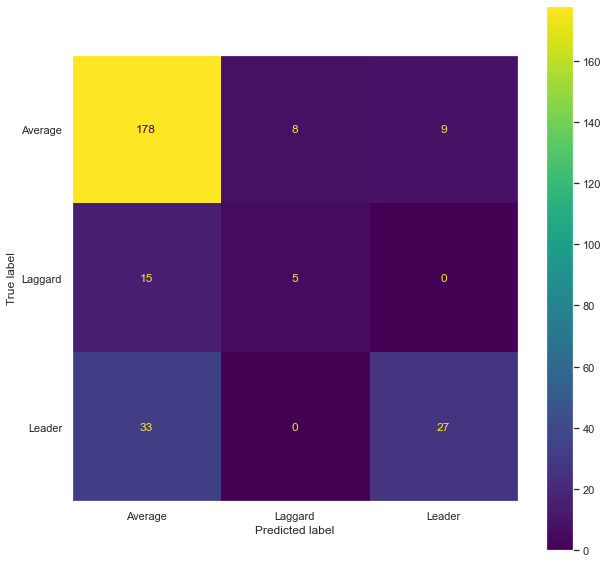

In [186]:
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(final_model_all, X_test2, y_test2, ax = ax)

ax.grid(False);

In [187]:
scoring(final_model_all, X_train2, X_test2, y_train2, y_test2)

Test Data Results:
 accuracy - 0.7636363636363637 
 precision - 0.7500959217773376 
 recall - 0.7636363636363637 
 F1 Score - 0.7443771552711306 

CV Results for `train_model` model:
            0.77037 ± 0.03573 accuracy
        


Great news! My models can predict overall esg class and binary env class at around a 75-77% level of precision and accuracy!